In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from apyori import apriori

## Подготовка данных

In [2]:
# Функция загрузки и подготовки данных
def load_data(filename):
    """
    Загружает данные из .CSV файла и преобразует их в список транзакций.
    
    :params:
    filename -- имя CSV-файла с покупками (товары в строке через запятую)
    
    :returns:
    transactions -- список списков (каждый внутренний список - это покупка)
    """
    # Читаем CSV, разделитель — запятая, без заголовков
    data = pd.read_csv(filename, header=None)
    
    # Преобразуем строки в списки товаров
    transactions = data.apply(lambda row: [item.strip() for item in row.dropna()], axis=1).tolist()
    
    return transactions


In [3]:
# Загружаем данные
data_path = "./data/baskets.csv"
transactions = load_data(data_path)
print(f"Загружено {len(transactions)} транзакций. Пример данных:")
for transaction in transactions[:5]:
    print(transaction)

Загружено 7501 транзакций. Пример данных:
['креветки', 'миндаль', 'авокадо', 'овощная смесь', 'зеленый виноград', 'цельнозерновая мука', 'батат', 'творог', 'энергетический напиток', 'томатный сок', 'низкокалорийный йогурт', 'зеленый чай', 'мед', 'салат', 'минеральная вода', 'лосось', 'ягодный сок', 'замороженный смузи', 'шпинат', 'оливковое масло']
['гамбургер', 'фрикадельки', 'яйца']
['чатни']
['индейка', 'авокадо']
['минеральная вода', 'молоко', 'энергетический батончик', 'рис', 'зеленый чай']


## Поиск ассоциативных правил

In [4]:
def run_apriori(transactions, min_support, min_confidence, sort_method = "support"):
    """
    Выполняет алгоритм Apriori с библиотекой apyori.
    
    :param:
    transactions -- список транзакций (списков товаров)
    min_support -- минимальный порог поддержки (в долях, например 0.05)
    min_confidence -- минимальный порог достоверности (в долях, например 0.7)
    
    :returns:
    DataFrame с найденными частыми наборами и их поддержкой
    """
    results = list(apriori(transactions, min_support=min_support, min_confidence=min_confidence))
    
    association_rules = []
    for result in results:
        for rule in result.ordered_statistics:
            antecedent = tuple(rule.items_base)
            consequent = tuple(rule.items_add)
            support = result.support
            confidence = rule.confidence
            association_rules.append((antecedent, consequent, support, confidence))
    
    df = pd.DataFrame(association_rules, columns=["antecedent", "consequent", "support", "confidence"])
    
    # Сортируем по заданному критерию
    if sort_method == "support":
        df = df.sort_values(by="support", ascending=False)
    elif sort_method == "lexicographic":
        df = df.sort_values(by="itemsets", ascending=True)
        
    return df

def filter_rules_by_length(association_rules, max_length=7):
    """
    Фильтрует ассоциативные правила по условию, что антецедент и консеквент суммарно не более max_length объектов.
    
    Аргументы:
    association_rules -- DataFrame с ассоциативными правилами
    max_length -- максимальное количество объектов в антецеденте и консеквенте
    
    Возвращает:
    DataFrame с отфильтрованными ассоциативными правилами
    """
    # Фильтруем правила по длине
    filtered_rules = association_rules[association_rules['antecedent'].apply(lambda x: len(x)) + association_rules['consequent'].apply(lambda x: len(x)) <= max_length]
    
    return filtered_rules


In [5]:
execution_time = list()
rule_count = list()
association_rules = list()

for min_confidence_value in range(20, 70, 5):
    start_time = time.time()
    received_association_rules = run_apriori(transactions, min_support=1/100, min_confidence=min_confidence_value/100, sort_method = "support")
    execution_time.append(time.time()-start_time)
    
    rule_count.append(len(received_association_rules))
    association_rules.append((min_confidence_value, received_association_rules))

In [6]:
for min_confidence_value, association_rules_df in association_rules:
    print(f"Минимальное значение достоверности {min_confidence_value:.0f}%: {association_rules_df.shape[0]} ассоциативных правил")
    print(association_rules_df)
    print("-"*40)
    

Минимальное значение достоверности 20%: 164 ассоциативных правил
                           antecedent           consequent   support  \
0                                  ()  (минеральная вода,)  0.238368   
61                        (макароны,)  (минеральная вода,)  0.061192   
62                (минеральная вода,)          (макароны,)  0.061192   
93                (минеральная вода,)           (шоколад,)  0.052660   
94                         (шоколад,)  (минеральная вода,)  0.052660   
..                                ...                  ...       ...   
136         (макароны, картофель-фри)  (минеральная вода,)  0.010399   
92                          (хлопья,)  (минеральная вода,)  0.010265   
128  (говяжий фарш, минеральная вода)              (яйца,)  0.010132   
110                            (суп,)           (шоколад,)  0.010132   
129              (говяжий фарш, яйца)  (минеральная вода,)  0.010132   

     confidence  
0      0.238368  
61     0.325532  
62     0.256711 

## Вывод графиков

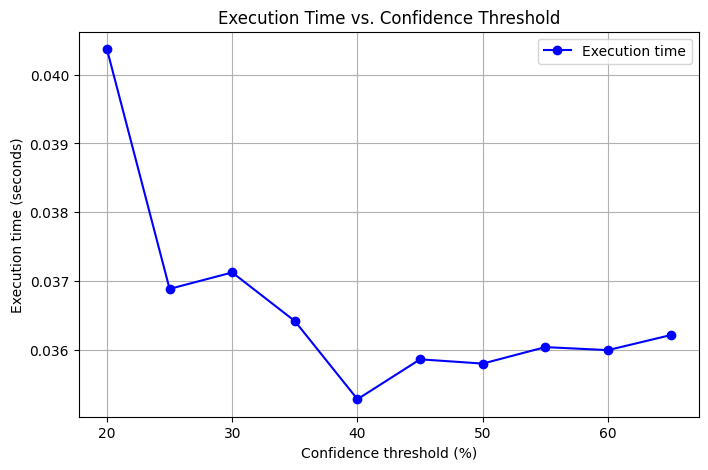

In [10]:
plt.figure(figsize=(8, 5))
plt.plot([s for s in range(20, 70, 5)], execution_time, marker="o", color="b", label="Execution time")
plt.xlabel("Confidence threshold (%)")
plt.ylabel("Execution time (seconds)")
plt.title("Execution Time vs. Confidence Threshold")
plt.legend()
plt.grid()
plt.show()

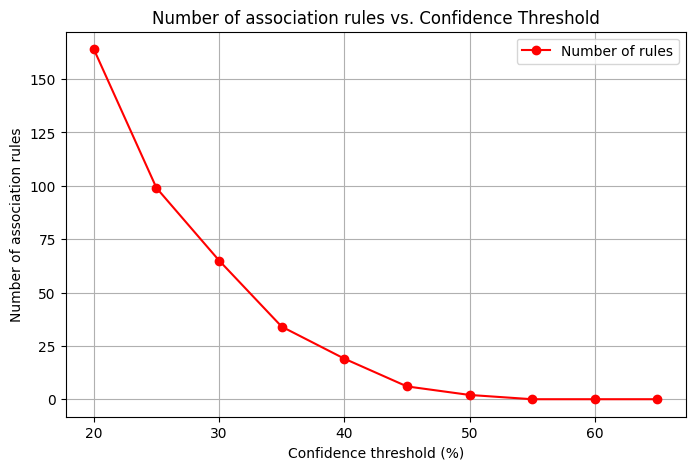

In [8]:
# Визуализируем данные
plt.figure(figsize=(8, 5))
plt.plot([c for c in range(20, 70, 5)], rule_count, marker="o", color="red", label="Number of rules")
plt.xlabel("Confidence threshold (%)")
plt.ylabel("Number of association rules")
plt.title("Number of association rules vs. Confidence Threshold")
plt.legend()
plt.grid()
plt.show()

### Вывод списка правил, где антецедент и консеквент суммарно включают в себя не более семи объектов

In [9]:
filtered_rules = filter_rules_by_length(run_apriori(transactions, min_support=1/100, min_confidence=20/100), max_length=7)
# Выводим отфильтрованные правила
filtered_rules

,antecedent,consequent,support,confidence
0,(),"(минеральная вода,)",0.238368,0.238368
61,"(макароны,)","(минеральная вода,)",0.061192,0.325532
62,"(минеральная вода,)","(макароны,)",0.061192,0.256711
93,"(минеральная вода,)","(шоколад,)",0.052660,0.220917
94,"(шоколад,)","(минеральная вода,)",0.052660,0.321400
...,...,...,...,...
136,"(макароны, картофель-фри)","(минеральная вода,)",0.010399,0.345133
92,"(хлопья,)","(минеральная вода,)",0.010265,0.398964
128,"(говяжий фарш, минеральная вода)","(яйца,)",0.010132,0.247557
110,"(суп,)","(шоколад,)",0.010132,0.200528
